In [1]:
# Import packages
import numpy as np
import pandas as pd
import chardet
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
import time

# Display plots inline
# matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from keras.callbacks import ModelCheckpoint 

from scipy import sparse, stats

Using TensorFlow backend.


In [2]:
# Download nltk - only need to run once
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sheik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Get encoding of data file
with open("author_data.csv", 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [4]:
# Load data (uncomment relevant line)
# Local version
#data = pd.read_csv("author_data.csv", encoding="Windows-1252")

# Floydhub version
data = pd.read_csv("author_data.csv", encoding="utf-8")
print(data.head())

                                                text        author
0  তুই আমাকে চিনিস না। আমি তোর চামড়া খুলে ফেলব।  ...  হুমায়ুনআহমেদ
1  আমরা কারও দাওয়াত কবুল করছি না, কারণ চৌধুরী সাহ...      শেখমুজিব
2  “তোমাকে খুঁজে বের করতে হবে খাতাঞ্জির ঘরে কেউ আ...      রবিঠাকুর
3  গণপরিষদের সদস্যদের লজ্জা না করলেও আমাদের লজ্জা...      শেখমুজিব
4  তাহলে তো মসজিদেই আটকা পড়ে থাকতে হবে।  তা ঠিক।...  জাহানারাইমাম


In [5]:
# Create feature (text) and label (author) lists
text = list(data['text'].values)
author = list(data['author'].values)

print("The author dataset contains {} datapoints.".format(len(text)))

The author dataset contains 4128 datapoints.


In [6]:
# Check distribution of authors in the data
Counter(author)

Counter({'হুমায়ুনআহমেদ': 516,
         'শেখমুজিব': 516,
         'রবিঠাকুর': 516,
         'জাহানারাইমাম': 516,
         ' কাজীনজরুলইসলাম': 516,
         'রকিবহাসান': 516,
         'বঙ্কিম_চট্টোপাধ্যায়': 516,
         'শরৎচন্': 516})

In [7]:
print(text[499])

বড়ো শক্ত হাতে পড়েছ বউ, বুঝে সুঝে চোলো।”  এমন সময় মোতির মাকে ঘরে ঢুকতে দেখেই বলে উঠল, “ভয় নেই, ভয় নেই, বকুলফুল, যাচ্ছি আমি। ভাবলুম তুমি নেই এই ফাঁকে আমাদের নতুন বউকে একবার দেখে আসি গে। তা সত্যি বটে, এ কৃপণের ধন, সাবধানে রাখতে হবে। সইকে বলছিলুম আমাদের দেওরের এ যেন হল আধ-কপালে মাথাধরা; বউকে ধরেছে ওর বাঁ দিকের পাওয়ার-কপালে, এখন ডান দিকের রাখার-কপালে যদি ধরতে পারে তবেই পুরোপুরি হবে।”  এই বলে ঘর থেকে বেরিয়ে গিয়ে মুহূর্ত পরে ঘরে ঢুকে কুমুর সামনে পানের ডিবে খুলে ধরে বললে, “একটা পান নেও। দোক্তা খাওয়া অভ্যেস আছে”?


In [8]:
print(text[999])

জিজ্ঞেস করল রবিন।  হ্যাঁ। এবং দশ লাখ ডলার।  খবরটা হজম করার সময় দিলেন সবাইকে, তারপর বললেন, হ্যারি আর বিংগো মুখ খুলেছে। ওদের সঙ্গে যে মেয়েমানুষটা ছিল, তার নাম ভিকি নরমা…না না, ভিকি, তুমি চমকে ওঠো না, তুমি না। আরেকজন। জেলে পচছে এখন। ডাকাতি করে সোজা লঙর্সবুর্গে গিয়ে এক হোটেলে উঠেছিল চারজনে। কিন্তু পরদিন অন্য তিনজনকে ফাঁকি দিয়ে সব টাকা নিয়ে কেটে পরে চোরের সর্দার বাড হিলারি। পালিয়ে আসে টুইন লেকসে। তারপর থেকে তার আর কোন খবর পায়নি সহকারীরা। ইতিমধ্যে আরেক চুরির কেসে ফেঁসে গিয়ে ধরা পড়ল ভিকি। কিন্তু হ্যারি আর বিংগোকে ধরতে পারেনি পুলিশ। তারা হিলারির লাশ পাওয়া গেছে শুনে ছুটে এসেছে টুইন লেকসে, টাকার সন্ধানে।  কিন্তু ম্যাকআরথার পেয়ে গিয়ে যে কোথাও লুকিয়ে রাখেনি, কি করে জানছেন?


In [9]:
print(text[1499])

বললেন, “উপায় কি, প্রত্যেক মাসেই লোকসান যাচ্ছে, কি করি?


In [10]:
print(text[1999])

পরদিন সকালে তাহার আফিসের আরদালির কাছে খবর পাইয়া অপূর্ব তেওয়ারীকে ডাকিয়া কহিল, একটা বাসার সন্ধান পাওয়া গেছে তেওয়ারী, গিয়ে দেখে আয় দেখি পোষাবে কিনা।  তেওয়ারী একটু হাসিয়া কহিল, আর বোধ হয় দরকার হবে না বাবু, সে-সব আমি ঠিক করে নিয়েছি। আসছে পয়লা তারিখে যারা যাবার তারাই যাবে। বাসা বদলানো ত সোজা ঝঞ্ঝাট নয় ছোটবাবু!


In [11]:
print(text[2499])

জিনা ঠিক মেনে নিতে পারছে না কিশোরের টিটকারি।  দেখে কিছু বুঝতে পারছ না?


In [12]:
print(text[2999])

হায় রে–  ভরা বাদর, মাহ ভাদর, শূন্য মন্দির মোর!


In [13]:
print(text[3499])

মধুসূদনের ইচ্ছে করতে লাগল, একটু দেরি না করে এখনই ওকে সঙ্গে করে নিয়ে যায়। ও আমার, ও আমারই, ও আমার ঘরের, আমার ঐশ্বর্যের, আমার সমস্ত দেহমনের, এই কথাটা উলটেপালটে বলতে ইচ্ছে করে।  পাশের ঘরে একটা সোফা দেখিয়ে কুমু যখন বসতে বললে, তখন ওকে বসতেই হল। নিতান্ত যদি বাইরের ঘর না হত তা হলে কুমুকে ধরে সোফায় আপনার পাশে বসাত। কুমু না বসে একটা চৌকির পিছনে তার পিঠের উপর হাত রেখে দাঁড়াল। বললে, “আমাকে কিছু বলতে চাও”?


In [14]:
print(text[3999])

চোখের পলকে তাহার অন্য কথা মনে পড়িল, কহিল, আজ কিন্তু তোমাকে ওই ছোট্ট ঘরটিতে শুতে হবে। নিজের হাতে আমি চমৎকার করে বিছানা করে দেব, কেমন?


In [15]:
# Create word count and character count lists
word_count = []
char_count = []

for i in range(len(text)):
    word_count.append(len(text[i].split()))
    char_count.append(len(text[i]))

# Convert lists to numpy arrays
word_count = np.array(word_count)
char_count = np.array(char_count)

# Calculate average word lengths
ave_length = np.array(char_count)/np.array(word_count)

In [16]:
def get_stats(var):
    """Print summary statistics for a variable of interest.
    
    Args:
    var: array. Numpy array containing values for the variable of interest.

    Returns:
    None
    """
    print("Min:", np.min(var))
    print("Max:", np.max(var))
    print("Mean:", np.mean(var))
    print("Median", np.median(var))
    print("1st percentile", np.percentile(var, 1))
    print("95th percentile", np.percentile(var, 95))
    print("99th percentile", np.percentile(var, 99))
    print("99.5th Percentile", np.percentile(var, 99.5))
    print("99.9th Percentile", np.percentile(var, 99.9))

In [17]:
print("Word count statistics")
get_stats(word_count)

Word count statistics
Min: 1
Max: 1550
Mean: 66.0876937984496
Median 26.0
1st percentile 1.0
95th percentile 267.64999999999964
99th percentile 518.46
99.5th Percentile 673.1899999999987
99.9th Percentile 1125.5870000000095


W0908 10:20:46.753823  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:20:46.759813  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:20:46.767817  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:20:46.774811  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:20:46.781803  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:20:46.788799  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:20:46.793794  2216 backend_ps.py:804] The PostScript ba

W0908 10:20:46.928716  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:20:46.930717  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:20:46.933711  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:20:46.936712  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:20:46.938710  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:20:46.941708  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:20:46.943707  2216 backend_ps.py:804] The PostScript ba

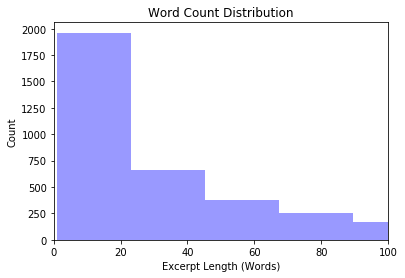

In [18]:
# Plot word count distribution
sns.distplot(word_count, kde = False, bins = 70, color = 'blue').set_title("Word Count Distribution")
plt.xlabel('Excerpt Length (Words)')
plt.ylabel('Count')
plt.xlim(0, 100)
plt.savefig("word_count.eps")

In [19]:
print("\nCharacter count statistics")
get_stats(char_count)


Character count statistics
Min: 5
Max: 10440
Mean: 393.3880813953488
Median 151.0
1st percentile 7.0
95th percentile 1624.2999999999993
99th percentile 3165.8200000000006
99.5th Percentile 3943.539999999957
99.9th Percentile 6761.871000000064


W0908 10:21:13.843964  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:13.846962  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:13.848961  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:13.851960  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:13.854961  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:13.856959  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:13.859957  2216 backend_ps.py:804] The PostScript ba

W0908 10:21:13.992879  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:13.995880  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:14.000874  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:14.003872  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:14.005873  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:14.007871  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:14.010870  2216 backend_ps.py:804] The PostScript ba

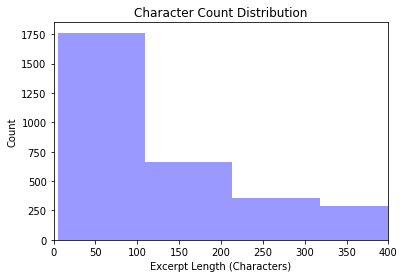

In [20]:
# Plot character count distribution
sns.distplot(char_count, kde = False, bins = 100, color = 'blue').set_title("Character Count Distribution")
plt.xlabel('Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 400)
plt.savefig("char_count.eps")

In [21]:
print("\nAverage length statistics")
get_stats(ave_length)


Average length statistics
Min: 3.0
Max: 17.0
Mean: 5.777383340977133
Median 5.769230769230769
1st percentile 3.6666666666666665
95th percentile 7.0
99th percentile 8.43562091503268
99.5th Percentile 9.377298136645944
99.9th Percentile 12.873000000000502


W0908 10:21:42.699808  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:42.702808  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:42.705805  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:42.708803  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:42.710805  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:42.713799  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:42.716799  2216 backend_ps.py:804] The PostScript ba

W0908 10:21:42.836731  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:42.839728  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:42.842727  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:42.844726  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:42.846724  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:42.849722  2216 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0908 10:21:42.851721  2216 backend_ps.py:804] The PostScript ba

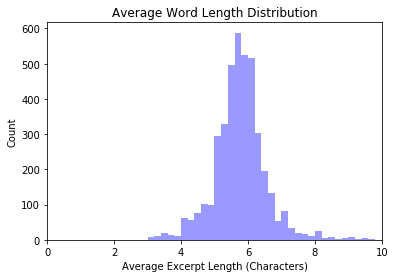

In [22]:
# Plot average excerpt length distribution
sns.distplot(ave_length, kde = False, bins = 70, color = 'blue').set_title("Average Word Length Distribution")
plt.xlabel('Average Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 10)
plt.savefig("ave_length.eps")

In [23]:
# Get word count outliers
word_outliers = np.where(word_count > 150)

for i in word_outliers[0]:
    print("Excerpt {} - Length: {}".format(i, word_count[i]))
    print(text[i], "\n")

Excerpt 3 - Length: 400
গণপরিষদের সদস্যদের লজ্জা না করলেও আমাদের লজ্জা করত। গণপরিষদের অধিকাংশ সদস্যই মুসলিম লীগার। মুসলিম লীগ নেতারা যখন লেজ গুটিয়ে আত্মসমর্পণ করল একমাত্র মরহুম তমিজুদ্দিন খান সাহেব গণপরিষদের প্রেসিডেন্ট হিসাবে গোলাম মোহাম্মদের এই আদেশের বিরুদ্ধে মামলা দায়ের করেন। আমরা জেলে বসে খবরের কাগজের মারফতে যেটুকু খবর পাই, তাই সম্বল, তাই নিয়েই আলোচনা করি।  কয়েকজন বন্দি মুক্তি পেয়েছেন। এখন আমি, ইয়ার মোহাম্মদ খান, দেওয়ান মাহবুব আলী, বিজয় চ্যাটার্জী, অধ্যাপক অজিত গুহ, মোহাম্মদ তোয়াহা ও কোরবান আলী এক জায়গায় থাকি। দিন আমাদের কেটে যাচ্ছে কোনোমতে। অজিত বাবু আমাদের খাওয়াদাওয়ার দেখাশোনা করতেন। বাবুর্চি তিনি ভালই ছিলেন। অসুস্থ হয়েও নিজেই পাক করতেন। তিনি মুক্তি পাওয়ার পরে তোয়াহা ভার নিল। অজিত বাবুর মত ভাল পাকাতে  পারলেও কোনোমতে চালিয়ে নিত। আমি ও দু’একজন তার পিছু নিতাম। সে রাগ হয়ে মাঝে মাঝে বসে থাকত। আবার অনুরোধ করে তাকে পাঠাতাম। তার রাগ বেশি সময় থাকত না। কোরবান আলীর একটু কষ্ট হত। ভাগে যা পড়ত তাতে তার হত না। শরীরটা বেশ ভাল ছিল, খেতেও পারত।  কোরবানকে একদিন জেলগেটে নিয়ে গেল মুক্তির কথা বলে। আম

যদি হতে ঐ মাধব চক্রবর্তীর মতো তা হলে আমাদের বড়োরানীরও দেবসেবা আজ ঘুচে যেত, আধপয়সাটির জন্যে তোমার হাতে পায়ে ধরাধরি করেই দিন কাটত। তাও বলি, তা হলে ওর উপকার হত, বানিয়ে বানিয়ে তোমার নিন্দে করবার এত সময় পেত না।  এমনি করে মেজোরানী অনর্গল বকে যেতে লাগলেন, তারই মাঝে মাঝে ছেঁচকিটা ঘন্টটা চিংড়িমাছের মুড়োটার প্রতিও ঠাকুরপোর মনোযোগ আকর্ষণ করা চলতে থাকল। আমার তখন মাথা ঘুরছে। আর তো সময় নেই, এখনই একটা উপায় করতে হবে। কী হতে পারে, কী করা যেতে পারে, এই কথা যখন বার বার মনকে জিজ্ঞাসা করছি তখন মেজোরানীর বকুনি আমার কাছে অত্যন্ত অসহ্য বোধ হতে লাগল। বিশেষত আমি জানি মেজোরানীর চোখে কিছুই এড়ায় না; তিনি ক্ষণে ক্ষণে আমার মুখের দিকে চাচ্ছিলেন, কী দেখছিলেন জানি নে, কিন্তু আমার মনে হচ্ছিল আমার মুখে সমস্ত কথাই যেন স্পষ্ট ধরা পড়ছিল।  দুঃসাহসের অন্ত নেই। আমি যেন নিতান্ত সহজ কৌতুকে হেসে উঠলুম; বলে উঠলুম, আসল কথা, আমার ‘পরেই মেজোরানীর যত অবিশ্বাস, চোর ডাকাত সমস্ত বাজে কথা।  মেজোরানী মুচকে হেসে বললেন, তা ঠিক বলেছিস লো, মেয়েমানুষের চুরি বড়ো সর্বনেশে। তা, আমার কাছে ধরা পড়তেই হবে, আমি তো আর পুরুষমানুষ নই। আমাকে ভোলাবি কী দিয়ে

In [24]:
word_outliers = np.where(word_count < 2)

for i in word_outliers[0]:
    print("Excerpt {} - Length: {}".format(i, word_count[i]))
    print(text[i], "\n")

Excerpt 39 - Length: 1
গ্রাম? 

Excerpt 81 - Length: 1
অ্যাঁ? 

Excerpt 179 - Length: 1
বাঁচাও! 

Excerpt 498 - Length: 1
মন্দেমাতরং! 

Excerpt 508 - Length: 1
ছায়াবাজি! 

Excerpt 593 - Length: 1
শরীফ? 

Excerpt 865 - Length: 1
গুণ্! 

Excerpt 894 - Length: 1
বাসায়? 

Excerpt 1286 - Length: 1
হুরা! 

Excerpt 1341 - Length: 1
গুণ্! 

Excerpt 1523 - Length: 1
খনিতে? 

Excerpt 1598 - Length: 1
পাজী! 

Excerpt 1672 - Length: 1
ভারতী? 

Excerpt 1750 - Length: 1
জিনা? 

Excerpt 1829 - Length: 1
হারামজাদা! 

Excerpt 1858 - Length: 1
কোনটা? 

Excerpt 1921 - Length: 1
সভাপতি? 

Excerpt 1943 - Length: 1
উঁ…কি? 

Excerpt 2226 - Length: 1
শুনছ? 

Excerpt 2249 - Length: 1
খবরদার! 

Excerpt 2390 - Length: 1
শুনলেন? 

Excerpt 2526 - Length: 1
গুণ্! 

Excerpt 2561 - Length: 1
“বিট্‌লে”! 

Excerpt 2589 - Length: 1
কর্তব্য! 

Excerpt 2615 - Length: 1
সুধাংশো! 

Excerpt 2709 - Length: 1
নিন্দ? 

Excerpt 2837 - Length: 1
ক্ষেপেচি? 

Excerpt 2866 - Length: 1
সর্বনাশ! 

Excerpt 2881 - Length: 1
দুর্বল! 

Ex

In [25]:
# Get average length outliers
length_outliers = np.where(ave_length > 10)

for i in length_outliers[0]:
    print("Excerpt {} - Average Length: {}".format(i, ave_length[i]))
    print(text[i], "\n")

Excerpt 208 - Average Length: 11.0
কোথায় কমলাকান্ত-প্রসূতি বঙ্গভূমি! 

Excerpt 498 - Average Length: 11.0
মন্দেমাতরং! 

Excerpt 1574 - Average Length: 12.0
অসংখ্য সন্তানকুল-পালিকে! 

Excerpt 2503 - Average Length: 16.5
শরৎসুন্দরি চারুপূর্ণচন্দ্রভালিকে! 

Excerpt 2651 - Average Length: 17.0
ডাকিব,-সিন্ধুসেবিতে সিন্ধু-পূজিতে সিন্ধু-মথনকারিণি! 

Excerpt 2910 - Average Length: 13.5
অনন্তশ্রী অনন্তকালস্থায়িনি! 

Excerpt 3012 - Average Length: 11.0
“পেটার্থী”! 

Excerpt 3016 - Average Length: 14.0
নগাঙ্কশোভিনি নগেন্দ্রবালিকে! 

Excerpt 3699 - Average Length: 10.666666666666666
শত্রুবধে দশভূজে দশপ্রহরণ-ধারিণি! 

Excerpt 3834 - Average Length: 13.0
জেন্টেলমেন্‌! 

Excerpt 3914 - Average Length: 10.5
﻿গোলেস্তান গোলেস্তান! 



In [26]:
length_outliers = np.where(ave_length < 3.5)

for i in length_outliers[0]:
    print("Excerpt {} - Average Length: {}".format(i, ave_length[i]))
    print(text[i], "\n")

Excerpt 493 - Average Length: 3.2
রথ যে আর চলে না! 

Excerpt 920 - Average Length: 3.3333333333333335
সে গৌড় কই? 

Excerpt 983 - Average Length: 3.0
এই কি মা? 

Excerpt 1316 - Average Length: 3.3333333333333335
কেমন হল ত? 

Excerpt 1377 - Average Length: 3.3333333333333335
– দূর ছাই! 

Excerpt 1518 - Average Length: 3.3333333333333335
এক জনও না? 

Excerpt 1878 - Average Length: 3.0
না তো! 

Excerpt 1961 - Average Length: 3.3333333333333335
বল ত দেখি? 

Excerpt 2237 - Average Length: 3.3333333333333335
সে তার কে? 

Excerpt 2299 - Average Length: 3.0
– ইস্! 

Excerpt 2468 - Average Length: 3.0
উঠ মা! 

Excerpt 2560 - Average Length: 3.3333333333333335
আছে বৈ কি! 

Excerpt 2783 - Average Length: 3.0
আর ভয় কী! 

Excerpt 3348 - Average Length: 3.25
– ওঃ কী আরাম! 

Excerpt 3405 - Average Length: 3.0
– আমি? 

Excerpt 3469 - Average Length: 3.0
ছি ছি! 

Excerpt 3502 - Average Length: 3.3333333333333335
তাই ত বটে! 

Excerpt 3667 - Average Length: 3.4285714285714284
যেন এ পথের আর শেষ না হয়! 



In [27]:
# Create string containing all excerpts in lower case
text_string = ''

for i in range(len(text)):
    text_string += text[i].lower()

# Get character frequencies
char_cnt = Counter(text_string)
print(char_cnt)
print(len(char_cnt))

Counter({' ': 274175, 'া': 144679, 'ে': 126477, 'র': 98062, 'ি': 70631, 'ন': 65390, 'ক': 64645, '্': 55357, 'ত': 48984, 'ব': 48062, 'ল': 47599, 'ম': 44068, 'স': 34927, 'দ': 29337, 'ু': 28250, 'প': 25683, '।': 24453, 'য়': 23822, 'হ': 22445, 'য': 21608, 'আ': 20743, 'ো': 19175, 'ছ': 17767, ',': 17553, 'ই': 17189, 'জ': 16748, 'গ': 15354, 'ট': 14699, 'এ': 13773, 'খ': 13468, 'শ': 12820, 'চ': 11129, 'ী': 10342, 'ও': 9390, 'থ': 8661, 'ভ': 8029, 'ধ': 7652, 'ড়': 6143, 'ষ': 5996, 'অ': 5915, '়': 5690, 'ফ': 4548, 'উ': 4463, 'ণ': 4337, 'ড': 4138, 'ঁ': 4078, 'ঠ': 3382, '-': 3139, 'ং': 3067, '?': 2748, 'ঙ': 2649, 'ূ': 2532, 'ঘ': 2403, 'ৃ': 1790, 'ঝ': 1606, '!': 1350, '“': 1234, '”': 1108, 'ঞ': 1078, 'ৌ': 871, 'e': 851, 'ঢ': 847, 'ৎ': 808, '–': 781, 't': 704, '’': 694, 'i': 645, 'n': 597, 'a': 591, 'ৈ': 568, 'o': 566, '১': 545, ';': 497, 'ঃ': 494, 's': 477, '—': 429, '‘': 412, 'r': 387, '.': 380, 'h': 354, 'd': 315, 'l': 301, '\u200c': 272, '৯': 270, 'ঐ': 250, 'c': 234, 'u': 226, '২': 223, 'm': 203, '

In [28]:
# Get character count dictionary keys
print(list(char_cnt.keys()))

['ত', 'ু', 'ই', ' ', 'আ', 'ম', 'া', 'ক', 'ে', 'চ', 'ি', 'ন', 'স', '।', 'ো', 'র', 'ড়', 'খ', 'ল', 'ফ', 'ব', 'জ', 'হ', 'ঙ', '্', 'গ', 'ী', ',', 'ছ', '?', 'ও', 'দ', 'য়', 'ণ', 'ৌ', 'ধ', 'প', 'য', 'থ', 'শ', 'এ', 'ং', 'ভ', 'ড', 'অ', '-', 'ঝ', 'ষ', 'ট', 'ঁ', '!', '“', 'ঞ', 'ঘ', 'উ', '”', '–', 'ঠ', 'ূ', 'ৈ', '’', 'ৃ', '৮', '.', '়', 'ঢ', 'ৎ', '‘', 'ঃ', 'ঐ', '\u200c', ';', 'ঊ', '৩', '১', '৯', '৭', '৪', ':', '২', '/', '(', ')', '০', '—', '…', '৫', 'a', 's', 'i', 't', 'c', 'r', 'e', 'h', 'd', 'o', 'y', 'u', 'n', 'ঈ', '5', 'f', 'l', 'w', '৬', '|', 'p', 'v', 'b', 'k', 'g', 'x', 'ৰ', 'ঔ', '1', 'm', '\ufeff', 'q', 'ঢ়', '8', 'j', '*', '9', '3', 'ঋ', '\u200d', '[', ']', '\u200e', 'z', '2', '4', '0', '7', '॥', '6', '৻', 'ৱ', '৺', '―', '&', '‛']


In [29]:
# Create list of accented characters
accented_chars = ['ï', 'é', 'ñ', 'è', 'ö', 'æ', 'ô', 'â', 'á', 'à', 'ê', 'ë']

# Find all texts containing unusual characters
accented_text = []

for i in range(len(text)):
    for j in text[i]:
        if j in accented_chars:
            accented_text.append(i)
        
accented_text = list(set(accented_text))
 
print('There are', str(len(accented_text)), 'texts containing accented characters.')

There are 0 texts containing accented characters.


In [30]:
# Print accented texts
for i in accented_text:
    print("Excerpt {}".format(i))
    print(text[i] + '\n')

In [31]:
# Remove invalid character from text
text = [excerpt.replace('\xa0', '') for excerpt in text]

In [32]:
# Verify character has been removed
unusual_text = []

for i in range(len(text)):
    for j in text[i]:
        if j == '\xa0':
            unusual_text.append(i)
        
unusual_text = list(set(unusual_text))
 
print('There are', str(len(unusual_text)), 'texts containing the invalid character.')

There are 0 texts containing the invalid character.


In [33]:
# Count texts containing white space blocks
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 2041 excerpts containing blocks of white space.


In [34]:
# Remove blocks of white space
new_text = []

for excerpt in text:
    while "  " in excerpt:
        excerpt = excerpt.replace("  "," ")
    new_text.append(excerpt)

text = new_text
print(len(text))

4128


In [35]:
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 0 excerpts containing blocks of white space.


In [36]:
normed_text = []

for i in range(len(text)):
    new = text[i].lower()
    new = new.translate(str.maketrans('','', string.punctuation))
    new = new.replace('“', '').replace('”', '')
    normed_text.append(new)
    
print(normed_text[0:5])    
print(len(normed_text))

['তুই আমাকে চিনিস না। আমি তোর চামড়া খুলে ফেলব। জাহাঙ্গীর বললেন গালাগালি কেন করছেন', 'আমরা কারও দাওয়াত কবুল করছি না কারণ চৌধুরী সাহেবই আমাদের প্রতিনিধি। তিনি যা করবেন তাই আমাদের করতে হবে। তিনি মালপত্র নিয়ে প্রথম শ্রেণী থেকে নেমে আসলেন এবং একজন ভদ্রলোককে বললেন চলুন আপনার ওখানেই যাওয়া যাবে। তিনি তাড়াতাড়ি গাড়ি ডেকে আমাদের নিয়ে চললেন। আমাদের জন্য কামরার অভাব নাই। গোসল করলাম খাওয়াদাওয়া করলাম। পরে বুঝতে পারলাম এরাই খাদেম। আজমীর শরীফের খাদেমদের যথেষ্ট ভদ্রতাবোধ আছে দেখলাম তারা কিছুই চেয়ে নেয় না। থাকার বন্দোবস্ত করবে খাবার ব্যবস্থা করবে সাথে লোক দেবে যে খরচগুলি করার একটা নিয়ম আছে সেগুলিই শুধু আপনাকে দিতে হবে। ফিরে আসার সময় আপনারা যা দিবেন তাই তারা গ্রহণ করবে। শুনেছি যে টাকা তারা গ্রহণ করে তার একটা অংশ নাকি দিতে হয় দরগাহ কমিটিকে। কারণ দরগাহ কমিটির যথেষ্ট খরচ আছে। খাজাবাবার দরগায় কোন লোক না খেয়ে থাকে না। পাক হতে থাকে মানুষ খেতে থাকে। আমরা দরগায় রওয়ানা করলাম পৌঁছে দেখি এলাহী কাণ্ড', 'তোমাকে খুঁজে বের করতে হবে খাতাঞ্জির ঘরে কেউ আনাগোনা করছে কি না। রতিকান্ত বিশ্বাসী লোক সে কি কখনো– তার অজান্তে মুহুর

In [37]:
text_train, text_test, author_train, author_test = train_test_split(normed_text, author, test_size = 0.2, random_state = 5)

In [38]:
# Check shapes of created datasets
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(author_train))
print(np.shape(author_test))

(3302,)
(826,)
(3302,)
(826,)


In [39]:
def create_n_grams(excerpt_list, n, vocab_size, seq_size):
    """Create a list of n-gram sequences
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    vocab_size: int. Size of n-gram vocab (used in one-hot encoding)
    seq_size: int. Size of n-gram sequences
    
    Returns:
    n_gram_array: array. Numpy array of one-hot encoded n-grams.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Convert to a single string with spaces between n-grams
        new_string = " ".join(n_grams)

        # One hot encode
        hot = one_hot(new_string, round(vocab_size*1.3))

        # Pad hot if necessary
        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    
    return n_gram_array

In [42]:
def get_vocab_size(excerpt_list, n, seq_size):
    """Calculate size of n-gram vocab
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    seq_size: int. Size of n-gram sequences
    
    Returns:
    vocab_size: int. Size of n-gram vocab.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams           
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Create list of n-grams
        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    # Flatten n-gram list
    n_gram_list = list(np.array(n_gram_list).flat)
    
    # Calculate vocab size
    n_gram_cnt = Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    
    return vocab_size

In [43]:
# Determine vocab sizes

for i in range(1, 4):
    vocab_size = get_vocab_size(text_train, i, 350)
    print('Vocab size for n =', i, 'is:', vocab_size)

Vocab size for n = 1 is: 124
Vocab size for n = 2 is: 3331
Vocab size for n = 3 is: 30349


In [44]:
# Create n-gram lists
gram1_train = create_n_grams(text_train, 1, 51, 350)
gram2_train = create_n_grams(text_train, 2, 966, 350)
gram3_train = create_n_grams(text_train, 3, 9521, 350)

gram1_test = create_n_grams(text_test, 1, 51, 350)
gram2_test = create_n_grams(text_test, 2, 966, 350)
gram3_test = create_n_grams(text_test, 3, 9521, 350)

print(np.shape(gram1_train))
print(np.shape(gram2_train))
print(np.shape(gram3_train))

print(np.shape(gram1_test))
print(np.shape(gram2_test))
print(np.shape(gram3_test))

(3302, 350)
(3302, 350)
(3302, 350)
(826, 350)
(826, 350)
(826, 350)


In [45]:
# Determine maximum value of n-gram encodings (this is used to set the CNN embedding dimension)
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Maximum encoding value for 1-grams is: ', max_1gram)
print('Maximum encoding value for 2-grams is: ', max_2gram)
print('Maximum encoding value for 3-grams is: ', max_3gram)

Maximum encoding value for 1-grams is:  65
Maximum encoding value for 2-grams is:  1255
Maximum encoding value for 3-grams is:  12376


In [46]:
def process_data(excerpt_list):
    """Stem data, remove stopwords and split into word lists
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    
    Returns:
    processed: list of strings. List of lists of processed text excerpts (stemmed and stop words removed).
    """
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    
    processed = []
    
    for excerpt in excerpt_list:
        new = excerpt.split()
        word_list = [porter.stem(w) for w in new if not w in stop_words]
        word_list = " ".join(word_list)
        processed.append(word_list)
    
    return processed

In [47]:
# Process data subsets
processed_train = process_data(text_train)
processed_test = process_data(text_test)

print(processed_train[0:5])

['আর যদি আমাদের সত্যিই তা মনে কর তা হলে তো তোমারই এ বিয়েতে সর্বপ্রথম অসম্মত হওয়া উচিত', 'আমি যে কী অসম্ভব কাঁচা তা এখানে এসে দুদিনে বুঝতে পেরেছি। সেই জন্যেই যখন উনি ভালোবাসেন তখনই আমার সব চেয়ে বেশি ভয় করে। আমি নিজের মধ্যে যে কিছুই খুঁজে পাই নে। এতবড়ো ফাঁকি নিয়ে আমি ওঁর সেবা করব কী করে', 'তোমাকে আর কি আসন দিব আমার এই হৃদয়াবরণের অর্দ্ধেকে উপবেশন কর। কুশকণ্টকাদি হইতে তোমার আচ্ছাদন জন্য আমি এই আপন অঙ্গ অনাবৃত করিতেছিআমার আঁচরে বসো। যাহাতে আমার লজ্জারক্ষা মানরক্ষা যাহাতে আমার শোভা হে মিলিত', 'এই বসন্তবর্ষার নিশীথিনীর মতোই আমার মনের মাঝে এসো তোমার গুঞ্জরণভরা ব্যথিত চরণ ফেলে', 'প্রতিবাদ করল ভিকি। সোনা আর রূপা অনেক সময় কাছাকাছিই পাওয়া যায় পকেট থেকে নুড়িটা বের করল কিশোর। জিনা তোমার চাচা কবে লর্ডসবুর্গ যাবেন কিছু বলেছেন']


In [48]:
# Create bag of words features
## Fit Tfidf Vectorizer
vectorizer = TfidfVectorizer(strip_accents = 'ascii', stop_words = 'english', min_df = 6)
vectorizer.fit(processed_train)

# Get size of vocabulary
print('Vocabulary size: ', len(vectorizer.vocabulary_))

# Create feature vectors
words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)

Vocabulary size:  1


In [49]:
# One hot encode labels
author_lb = LabelBinarizer()

author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [50]:
# Define model architecture in keras
# Code reference: https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
def define_model(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    """Define n-gram CNN
    
    Args:
    input_len: int. Length of input sequences.
    output_size: int. Number of output classes.
    vocab_size: int. Maximum value of n-gram encoding.
    embedding_dim: int. Size of embedding layer.
    verbose: bool. Whether or not to print model summary.
    drop_out_pct: float. Drop-out rate.
    conv_filters: int. Number of filters in the conv layer.
    activation_fn: string. Activation function to use in the convolutional layer.
    pool_size: int. Pool size for the max pooling layer.
    learning: float. Learning rate for the model optimizer.
    
    Returns:
    model: keras model object. 
    """
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [51]:
# Create the 1-gram model
gram1_model = define_model(350, 8, max_1gram + 1, 26)

W0908 10:40:43.309002  2216 deprecation_wrapper.py:119] From C:\Users\sheik\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0908 10:40:44.742185  2216 deprecation_wrapper.py:119] From C:\Users\sheik\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0908 10:40:45.125969  2216 deprecation_wrapper.py:119] From C:\Users\sheik\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0908 10:40:45.463767  2216 deprecation_wrapper.py:119] From C:\Users\sheik\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0908 10:40:45.515740  2216 deprecation.py:506

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 350, 26)      1716        input_1[0][0]                    
____________________________________________________________________________________________

In [52]:
# Train 1-gram CNN
gram1_model.fit([gram1_train, gram1_train, gram1_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

W0908 10:41:30.443022  2216 deprecation.py:323] From C:\Users\sheik\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2641 samples, validate on 661 samples
Epoch 1/10
2641/2641 [==============================] - 67s 25ms/step - loss: 2.0613 - acc: 0.1776 - val_loss: 2.0361 - val_acc: 0.1846
Epoch 2/10
2641/2641 [==============================] - 63s 24ms/step - loss: 2.0128 - acc: 0.2033 - val_loss: 2.0219 - val_acc: 0.1876
Epoch 3/10
2641/2641 [==============================] - 53s 20ms/step - loss: 1.9681 - acc: 0.2469 - val_loss: 1.9770 - val_acc: 0.2148
Epoch 4/10
2641/2641 [==============================] - 52s 20ms/step - loss: 1.8698 - acc: 0.3041 - val_loss: 1.9187 - val_acc: 0.2693
Epoch 5/10
2641/2641 [==============================] - 50s 19ms/step - loss: 1.6937 - acc: 0.4267 - val_loss: 1.7875 - val_acc: 0.3313
Epoch 6/10
2641/2641 [==============================] - 49s 19ms/step - loss: 1.5032 - acc: 0.5206 - val_loss: 1.6851 - val_acc: 0.3888
Epoch 7/10
2641/2641 [==============================] - 50s 19ms/step - loss: 1.3389 - acc: 0.5850 - val_loss: 1.6298 - val_acc: 0.3933
E

In [53]:
# Create the 2-gram model
gram2_model = define_model(350, 8, max_2gram + 1, 300)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 350, 300)     376800      input_4[0][0]                    
____________________________________________________________________________________________

In [54]:
# Train 2-gram CNN
gram2_model.fit([gram2_train, gram2_train, gram2_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Train on 2641 samples, validate on 661 samples
Epoch 1/10
2641/2641 [==============================] - 190s 72ms/step - loss: 2.0702 - acc: 0.1719 - val_loss: 2.0427 - val_acc: 0.1876
Epoch 2/10
2641/2641 [==============================] - 183s 69ms/step - loss: 1.9638 - acc: 0.2567 - val_loss: 2.0245 - val_acc: 0.2179
Epoch 3/10
2641/2641 [==============================] - 197s 75ms/step - loss: 1.8583 - acc: 0.3423 - val_loss: 1.9521 - val_acc: 0.2829
Epoch 4/10
2641/2641 [==============================] - 204s 77ms/step - loss: 1.6459 - acc: 0.5343 - val_loss: 1.7473 - val_acc: 0.4266
Epoch 5/10
2641/2641 [==============================] - 193s 73ms/step - loss: 1.3412 - acc: 0.6759 - val_loss: 1.5302 - val_acc: 0.4781
Epoch 6/10
2641/2641 [==============================] - 197s 75ms/step - loss: 1.0507 - acc: 0.7486 - val_loss: 1.3000 - val_acc: 0.5658
Epoch 7/10
2641/2641 [==============================] - 198s 75ms/step - loss: 0.8501 - acc: 0.7925 - val_loss: 1.1855 - val_acc: 0

In [55]:
# Create the 3-gram model
gram3_model = define_model(350, 8, max_3gram + 1, 600)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 350, 600)     7426200     input_7[0][0]                    
____________________________________________________________________________________________

In [56]:
# Train 3-gram CNN
gram3_model.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Train on 2641 samples, validate on 661 samples
Epoch 1/10
2641/2641 [==============================] - 399s 151ms/step - loss: 2.0776 - acc: 0.1757 - val_loss: 2.0489 - val_acc: 0.1589
Epoch 2/10
2641/2641 [==============================] - 392s 148ms/step - loss: 1.9163 - acc: 0.2764 - val_loss: 2.0144 - val_acc: 0.1936
Epoch 3/10
2641/2641 [==============================] - 438s 166ms/step - loss: 1.7570 - acc: 0.3771 - val_loss: 1.9665 - val_acc: 0.2133
Epoch 4/10
2641/2641 [==============================] - 394s 149ms/step - loss: 1.5250 - acc: 0.6354 - val_loss: 1.8223 - val_acc: 0.2799
Epoch 5/10
2641/2641 [==============================] - 389s 147ms/step - loss: 1.2020 - acc: 0.7486 - val_loss: 1.5266 - val_acc: 0.5310
Epoch 6/10
2641/2641 [==============================] - 364s 138ms/step - loss: 0.8898 - acc: 0.8436 - val_loss: 1.2925 - val_acc: 0.5779
Epoch 7/10
2641/2641 [==============================] - 362s 137ms/step - loss: 0.6698 - acc: 0.8720 - val_loss: 1.1210 - val

In [57]:
# Define function for plotting normalized confusion matrix
# Code reference 1: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# Code reference 2: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Args:
    cm: matrix. Confusion matrix for plotting.
    classes: list. List of class labels.
    normalize: bool. Whether or not to normalize the confusion matrix.
    title: string. Title for plot.
    cmap: color map. Color scheme for plot.
    
    Returns:
    None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
       
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap = cmap)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)

In [58]:
# Fit and evaluate Model 1 (3-gram CNN)

t0 = time.time()

# Fit model
model1 = define_model(350, 8, max_3gram + 1, 600)
model1.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, 
           verbose = 1, validation_split = 0.2)
t1 = time.time()

# Predict values for test set
author_pred1 = model1.predict([gram3_test, gram3_test, gram3_test])

t2 = time.time()

# Reverse one-hot encoding of labels
author_pred1 = author_lb.inverse_transform(author_pred1)

# Evaluate
accuracy = accuracy_score(author_test, author_pred1)
precision, recall, f1, support = score(author_test, author_pred1)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred1, labels = ['হুমায়ুনআহমেদ', 'রবিঠাকুর', 'রকিবহাসান', 'বঙ্কিম_চট্টোপাধ্যায়', 
                                                                  'কাজীনজরুলইসলাম', 'শেখমুজিব', 'জাহানারাইমাম', 'শরৎচন্দ্র'])
    
print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 350, 600)     7426200     input_10[0][0]                   
____________________________________________________________________________________________

C:\Users\sheik\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix
[[0.38       0.05       0.17       0.19       0.         0.21
  0.         0.        ]
 [0.25301205 0.37349398 0.09638554 0.24096386 0.         0.03614458
  0.         0.        ]
 [0.04301075 0.         0.77419355 0.13978495 0.         0.04301075
  0.         0.        ]
 [0.01515152 0.         0.         0.98484848 0.         0.
  0.         0.        ]
 [       nan        nan        nan        nan        nan        nan
         nan        nan]
 [0.11702128 0.         0.04255319 0.13829787 0.         0.70212766
  0.         0.        ]
 [0.10227273 0.         0.11363636 0.26136364 0.         0.04545455
  0.47727273 0.        ]
 [       nan        nan        nan        nan        nan        nan
         nan        nan]]


C:\Users\sheik\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 2489 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sheik\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 2497 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sheik\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 2478 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sheik\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 2494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sheik\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 2527 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sheik\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 2472 missing from current

C:\Users\sheik\Anaconda3\lib\site-packages\matplotlib\backends\_backend_pdf_ps.py:62: RuntimeWarning: Glyph 2489 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
C:\Users\sheik\Anaconda3\lib\site-packages\matplotlib\backends\_backend_pdf_ps.py:62: RuntimeWarning: Glyph 2497 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
C:\Users\sheik\Anaconda3\lib\site-packages\matplotlib\backends\_backend_pdf_ps.py:62: RuntimeWarning: Glyph 2478 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
C:\Users\sheik\Anaconda3\lib\site-packages\matplotlib\backends\_backend_pdf_ps.py:62: RuntimeWarning: Glyph 2494 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
C:\Users\sheik\Anaconda3\lib\site-packages\matplotlib\backends\_backend_pdf_ps.py:62: RuntimeWarning: Glyph 2527 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
C:\Users\sheik\Anaconda3\

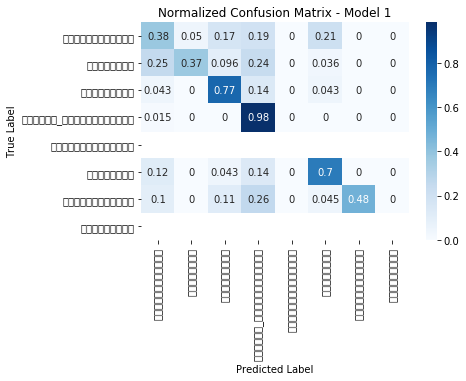

In [59]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion, classes=['হুমায়ুনআহমেদ', 'রবিঠাকুর', 'রকিবহাসান', 'বঙ্কিম_চট্টোপাধ্যায়', 
                                          'কাজীনজরুলইসলাম', 'শেখমুজিব', 'জাহানারাইমাম', 'শরৎচন্দ্র'], \
                      normalize=True, title='Normalized Confusion Matrix - Model 1')

plt.savefig("confusion1.eps")

In [60]:
# Fit and evaluate Model 2 (Bag of words SVM)
np.random.seed(28)

t0 = time.time()

# Fit model
model2 = SVC(C = 1, kernel = 'linear')
model2.fit(words_train, author_train)

t1 = time.time()

# Predict values for test set
author_pred2 = model2.predict(words_test)

t2 = time.time()

# Evaluate
accuracy = accuracy_score(author_test, author_pred2)
precision, recall, f1, support = score(author_test, author_pred2)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred2, labels =  ['হুমায়ুনআহমেদ', 'রবিঠাকুর', 'রকিবহাসান', 'বঙ্কিম_চট্টোপাধ্যায়', 
                                                                  'কাজীনজরুলইসলাম', 'শেখমুজিব', 'জাহানারাইমাম', 'শরৎচন্'])

print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)

Accuracy: 0.1162227602905569
Ave. Precision: 0.01350773000955625
Ave. Recall: 0.1162227602905569
Ave. F1 Score: 0.024202570472653933
Training Time: 0.783552885055542 seconds
Prediction Time: 0.09696316719055176 seconds
Confusion Matrix:
 [[  0   0   0   0   0 108   0   0]
 [  0   0   0   0   0 105   0   0]
 [  0   0   0   0   0  98   0   0]
 [  0   0   0   0   0 103   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  96   0   0]
 [  0   0   0   0   0 100   0   0]
 [  0   0   0   0   0 108   0   0]]


C:\Users\sheik\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C:\Users\sheik\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix
[[ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [nan nan nan nan nan nan nan nan]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]]


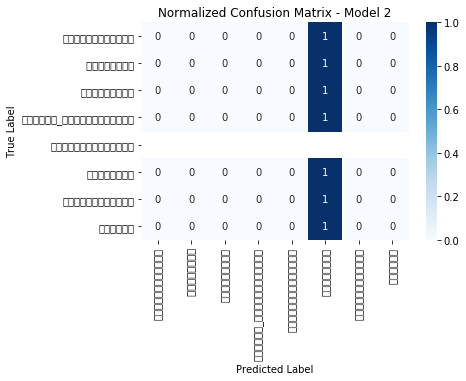

In [61]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion, classes=['হুমায়ুনআহমেদ', ' রবিঠাকুর', 'রকিবহাসান', 'বঙ্কিম_চট্টোপাধ্যায়', 
                                          'কাজীনজরুলইসলাম', 'শেখমুজিব', 'জাহানারাইমাম', 'শরৎচন্'], \
                      normalize=True, title='Normalized Confusion Matrix - Model 2')

plt.savefig("confusion2.eps")

In [62]:
# Get benchmark statistics (random model)

# Perform 10 times and take averages

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []

for i in range(10):
    # Create random predictions
    author_pred3 = np.random.choice(['হুমায়ুনআহমেদ', 'রবিঠাকুর', 'রকিবহাসান', 'বঙ্কিম_চট্টোপাধ্যায়', 
                                'কাজীনজরুলইসলাম', 'শেখমুজিব', 'জাহানারাইমাম', 'শরৎচন্দ্র'], len(author_test))

    # Evaluate
    accuracy = accuracy_score(author_test, author_pred3)
    precision, recall, f1, support = score(author_test, author_pred3)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list, np.mean(accuracy_list), np.std(accuracy_list))
print("Ave. Precision:", prec_list, np.mean(prec_list), np.std(prec_list))
print("Ave. Recall:", recall_list, np.mean(recall_list), np.std(recall_list))
print("Ave. F1 Score:", f1_list, np.mean(f1_list), np.std(f1_list))

Accuracy: [0.07869249394673124, 0.09564164648910412, 0.10048426150121065, 0.1053268765133172, 0.08595641646489104, 0.09079903147699758, 0.0811138014527845, 0.09322033898305085, 0.08837772397094432, 0.08958837772397095] 0.09092009685230025 0.007779333572114936
Ave. Precision: [0.07889780841695937, 0.09424342009201182, 0.09750683396750676, 0.10730844338416481, 0.08627780234141491, 0.09135745202187777, 0.0790019508952311, 0.09130661818239767, 0.08709822202496353, 0.08751620835776784] 0.09005147596842956 0.008063031971872045
Ave. Recall: [0.07869249394673124, 0.09564164648910412, 0.10048426150121065, 0.1053268765133172, 0.08595641646489104, 0.09079903147699758, 0.0811138014527845, 0.09322033898305085, 0.08837772397094432, 0.08958837772397095] 0.09092009685230025 0.007779333572114936
Ave. F1 Score: [0.07864633844267366, 0.09450295146729033, 0.09855761175693681, 0.10529315115184357, 0.08599954972032813, 0.09081156572873622, 0.07972636040433691, 0.09196349617960448, 0.08731833991358962, 0.088

C:\Users\sheik\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [63]:
# Model 1 Sensitivity Testing

kf = KFold(n_splits = 3)

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
cnt = 0


for train_inds, _ in kf.split(gram3_train):
    cnt += 1
    print('Run:', cnt)
       
    # Create data subsets
    train_x = np.array([gram3_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
       
    # Fit model
    model1 = define_model(350, 8, max_3gram + 1, 600, verbose = False)
    model1.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, verbose = 0)
    
    # Predict values for test set
    author_pred1 = model1.predict([gram3_test, gram3_test, gram3_test])
    author_pred1 = author_lb.inverse_transform(author_pred1)

    # Evaluate
    accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Run: 2
Run: 3
Accuracy: [0.6065375302663438, 0.6004842615012107, 0.5617433414043583]
Ave. Precision: [0.6229906567485032, 0.6231938322557435, 0.5986223347333859]
Ave. Recall: [0.6065375302663438, 0.6004842615012107, 0.5617433414043583]
Ave. F1 Score: [0.5917587132028472, 0.5823142289838833, 0.552567646537896]


In [64]:
# Explore the first 100 test examples
for i in range(100):
    print('Excerpt', i, '- Actual label =', author_test[i],  'Model 1 predicted label =', author_pred1[i], 
         'Model 2 predicted label =', author_pred2[i])
    print(text_test[i], '\n')

Excerpt 0 - Actual label = হুমায়ুনআহমেদ Model 1 predicted label =  কাজীনজরুলইসলাম Model 2 predicted label = শেখমুজিব
তিনি একজন প্রেসের মালিক। প্রেসের নাম ‘আদর্শলিপি’। চিঠিতে কী লেখা 

Excerpt 1 - Actual label = শরৎচন্ Model 1 predicted label = শরৎচন্ Model 2 predicted label = শেখমুজিব
ভারতী আকুল হইয়া তাঁহার হাত চাপিয়া ধরিয়া কহিল সে কিছুতেই হতে পারবে না। তুমি সঙ্গে চল। কিন্তু কথাটা উচ্চারণ করিয়া সে সুমিত্রার মতই অপ্রতিভ হইল। কারণ ইঁহার বলা মানেই স্থির করিয়া বলা। এবং সংসারের কোন ভয়ই তাঁহাকে নিরস্ত করিতে পারিবে না। তথাপি ভারতী হাত ছাড়িয়াও দিল না ধীরে ধীরে কহিল কিন্তু তোমাকে যে আমার বড় দরকার দাদা 

Excerpt 2 - Actual label = জাহানারাইমাম Model 1 predicted label = জাহানারাইমাম Model 2 predicted label = শেখমুজিব
পৌঁছাতে এত দেরি হল যে 

Excerpt 3 - Actual label = শেখমুজিব Model 1 predicted label = শেখমুজিব Model 2 predicted label = শেখমুজিব
জুবেরী সাহেবের কাছে হাজির হতাম। আমি অন্যায় আবদার করতাম না। তাই শিক্ষকরা আমার কথা শুনতেন। ছাত্ররাও আমাকে ভালবাসত। হোস্টেল সুপারিনটেনডেন্ট সাইদুর রহমান সাহে

আর ভাই ঢেঁকি আর একটা কথা জিজ্ঞাসা করিমধ্যে মধ্যে স্বর্গে যাওয়া হয় শুনিয়াছি সত্য সত্যই কি সেখানে গিয়াও ধান ভানিতে হয় 

Excerpt 27 - Actual label = হুমায়ুনআহমেদ Model 1 predicted label = রকিবহাসান Model 2 predicted label = শেখমুজিব
একজন পেছন থেকে শফিকের মাথার টুপি সরিয়ে দিল। শফিকের চোখে ধাঁধা লেগেছে। মনে হচ্ছে ঘরে সার্চলাইট জ্বলছে। সে চোখ কচলাতে কচলাতে বলল স্যার নয়টা আলপিন। ভালোমতো শুনে বলুন। স্যার দশটা। কোনো প্রশ্নের মিথ্যা উত্তর দিলে একটা আলপিন নখের নিচে এক ইঞ্চির মতো ঢুকিয়ে দেব। দশটা ভুল উত্তর দেবেন দশ আঙুলে দশটা আলপিন নিয়ে হাজতে ফিরে যাবেন। বুঝতে পারছেন 

Excerpt 28 - Actual label = রকিবহাসান Model 1 predicted label = রকিবহাসান Model 2 predicted label = শেখমুজিব
পাবে হয়তো কেউ একদিন পাহাড়ের ওদিকে মরচেটরচে পড়া অবস্থায়। হাঁটতে হাঁটতে বাড়ির উত্তর ধারে পুরানো একটা ঘরের কাছে চলে এলেন মিসেস ফিলটার। বললেন মিলানোর ঘর ছিল এটা। খনির পেমাস্টার ছিল সে। দরজায় ঠেলা দিলেন মিসেস ফিলটার। মৃদু ক্যাচকোচ প্রতিবাদ জানিয়ে খুলে গেল দরজা। সবাইকে নিয়ে ভেতরে ঢুকলেন। দীর্ঘ দিনের অব্যবহৃত আসবাবপত্র দেয়ালের প্লাস

আবার তো ফিরে আসব। কিন্তু আমি জানি আমি আর ফিরব না। তোমায় এতদিন বলিনি লুকিয়ে রেখেছিলুম কিন্তু আজ যাবার দিনে কষ্ট পাবে জেনেও জানিয়ে যাচ্ছি। আমার যক্ষ্মা হয়েছে – যাকে আমাদের দেশে শিবের অসাধ্য রোগ বলে। ডাক্তার কতবার আমায় পরিশ্রম করতে মানা করেছে আমার কত বন্ধু আমায় কত মিনতি করে হাতেপায়ে ধরে এখন কিছু দিনের জন্যে বিশ্রাম করতে বলেছে আর আমি ততই দ্বিগুণ বেগে কাজ করেছি। সে সময় তুমি যদি আমায় একটিবার মানা করতে 

Excerpt 46 - Actual label = রকিবহাসান Model 1 predicted label = রকিবহাসান Model 2 predicted label = শেখমুজিব
একটাই কাজ এখন করার কাছে আমাদের। কী 

Excerpt 47 - Actual label = শেখমুজিব Model 1 predicted label = বঙ্কিম_চট্টোপাধ্যায় Model 2 predicted label = শেখমুজিব
হুকুমনামা সময়মত আসে নাই কেন 

Excerpt 48 - Actual label = হুমায়ুনআহমেদ Model 1 predicted label = শেখমুজিব Model 2 predicted label = শেখমুজিব
পারেন তবে থানার টেলিফোন এখন নষ্ট। যান হাজতে অপেক্ষা করুন। টেলিফোন ঠিক হলে আপনাকে খবর দেওয়া হবে। সারা দিনেও টেলিফোন ঠিক হলো না। শফিক ঠিক করল কোনো কারণে যদি সে বেঁচে যায় তাহলে আর ঢাকায় থাকবে না। ম

Excerpt 62 - Actual label = জাহানারাইমাম Model 1 predicted label = জাহানারাইমাম Model 2 predicted label = শেখমুজিব
সে নিশ্চয় জানত এরকমটাই ঘটবে তার পরিবারপরিজনদের জীবনে। তা জেনেই সে তাদেরকে পেছনে ফেলে সামনের পথ ধরে চলে গিয়েছিল অনিশ্চয়ের দিকে। সর্বনাশের কিনারায় দাঁড়িয়ে সে পালিয়ে আসা বিদ্রোহী বাঙালি সামরিক বাহিনীর অফিসার জওয়ান আর যুদ্ধকামী শত শত যুবককিশোরদের জড়ো করে মুক্তিযুদ্ধ সংগঠিত করার দুরূহ কাজে মগ্ন হয়েছিল। ঢাকা থেকে তার ফ্যামিলির খবর প্রথম সে পায় তার বন্ধুর ছোট ভাই শহীদুল্লাহ খান বাদলের মারফত। বাদল এবং তার তিন বন্ধু আসফাকুস সামাদ অ্যাসফী মাসুদ ও বদি ২৭ মার্চেই ঢাকা ছাড়ে তাদের বিশ্বাস হয় পাক আর্মির এতবড় ক্র্যাকডাউনের পর নিশ্চয়ই কোথাও না কোথাও প্রতিরোধ গড়ে উঠেছে। তারাও যোগ দিতে চায় সেই প্রতিরোধ সংগ্রামে। তারা যুদ্ধের খোঁজে বেরিয়ে পড়ে। তারা তখনও জানত না খালেদ মোশাররফ কোথায় আছে। কিন্তু পথে নানাজনের সঙ্গে দেখা হতে হতে এবং নানা ঘটনা ঘটতে ঘটতে শেষমেষ খালেদ মোশাররফের সঙ্গেই তাদের যোগাযোগ ঘটে যায়। খালেদ বাদলকে বলে এটা একটা দীর্ঘস্থায়ী যুদ্ধ হবে। এর জন্য দরকার রেগুলার আ

In [65]:
def calculate_averages(true, pred, text):
    """Calculate average length of correctly and incorrectly classified examples
    
    Args:
    true: list. List of correct labels.
    pred: list. List of predicted labels.
    text: list. List of text excerpts.
    
    Returns:
    correct_ave_chars: float. Average length of correctly classified examples in characters.
    incorrect_ave_chars: float. Average length of incorrectly classified examples in characters.
    correct_ave_words: float. Average length of correctly classified examples in characters.
    incorrect_ave_words: float. Average length of incorrectly classified examples in characters.
    """
    
    correct_len_chars = []
    incorrect_len_chars = []
    correct_len_words = []
    incorrect_len_words = []

    
    for i in range(len(true)):
        if true[i] == pred[i]:
            correct_len_chars.append(len(text[i]))
            correct_len_words.append(len(text[i].split()))
        else:
            incorrect_len_chars.append(len(text[i]))
            incorrect_len_words.append(len(text[i].split()))
    
    correct_ave_chars = np.mean(correct_len_chars)
    correct_ave_words = np.mean(correct_len_words)
    incorrect_ave_chars = np.mean(incorrect_len_chars)
    incorrect_ave_words = np.mean(incorrect_len_words)
    
    # Conduct two sample t-test
    print('Character t-test')
    print(stats.ttest_ind(correct_len_chars, incorrect_len_chars, equal_var = False))
    
    print('\nWord t-test')
    print(stats.ttest_ind(correct_len_words, incorrect_len_words, equal_var = False))
    
    return correct_ave_chars, correct_ave_words, incorrect_ave_chars, incorrect_ave_words

In [66]:
# Calculate averages for Model 1
correct_ave_chars1, correct_ave_words1, incorrect_ave_chars1, incorrect_ave_words1\
= calculate_averages(author_test, author_pred1, text_test)

Character t-test
Ttest_indResult(statistic=7.555977426163711, pvalue=1.275998642913031e-13)

Word t-test
Ttest_indResult(statistic=7.734018619503766, pvalue=3.6628278418749625e-14)


In [67]:
# Calculate averages for Model 2
correct_ave_chars2, correct_ave_words2, incorrect_ave_chars2, incorrect_ave_words2\
= calculate_averages(author_test, author_pred2, text_test)

Character t-test
Ttest_indResult(statistic=5.429372785974848, pvalue=4.0057130832963724e-07)

Word t-test
Ttest_indResult(statistic=5.3481490554074975, pvalue=5.70023367413591e-07)


In [68]:
print('Model 1 - Average excerpt length (chars) of correct examples =', correct_ave_chars1, 
        'Incorrect exampes =', incorrect_ave_chars1)
print('Model 2 - Average excerpt length (chars) of correct examples =', correct_ave_chars2, 
      'Incorrect exampes =', incorrect_ave_chars2)

print('\nModel 1 - Average excerpt length (words) of correct examples =', correct_ave_words1, 
        'Incorrect exampes =', incorrect_ave_words1)
print('Model 2 - Average excerpt length (words) of correct examples =', correct_ave_words2, 
      'Incorrect exampes =', incorrect_ave_words2)

Model 1 - Average excerpt length (chars) of correct examples = 482.5603448275862 Incorrect exampes = 200.92265193370164
Model 2 - Average excerpt length (chars) of correct examples = 887.90625 Incorrect exampes = 289.5931506849315

Model 1 - Average excerpt length (words) of correct examples = 83.4353448275862 Incorrect exampes = 34.5939226519337
Model 2 - Average excerpt length (words) of correct examples = 151.875 Incorrect exampes = 50.21506849315068
